In [28]:
# import
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

from scipy.optimize import linear_sum_assignment
from shapely import geometry
import matplotlib.patches as mpatches
import pandas as pd
from skimage.transform import resize

import os.path

1273555961.py (6): Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [29]:
np.random.seed(6)
lbl_cmap = random_label_cmap()

In [30]:
# directories
base_dir = "./"
path_tif_dataset = base_dir + "dataset/raw-data/"
path_csv_pred = base_dir + "dataset/single-channel-images/predictions_annotation.csv"
path_csv_groundtruth = base_dir + "dataset/raw-data/annotations.csv" # not needed for the first part

### Load centriole values and choose image

In [31]:
# load csv predictions for centrioles
pred_cen_df = pd.read_csv(path_csv_pred)
# display all possible predictions too choose from
uni_img_names = pred_cen_df.image_name.unique()
print("Choose image from list")
for c, name in enumerate(uni_img_names):
    print("No.", c, "Name", name)

Choose image from list
No. 0 Name RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask
No. 1 Name RPE1wt_CEP63+CETN2+PCNT_1_004_002_max_C3_mask
No. 2 Name RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C1_mask
No. 3 Name RPE1wt_CP110+GTU88+PCNT_2_003_003_max_C1_mask
No. 4 Name RPE1wt_CEP152+GTU88+PCNT_1_001_001_max_C1_mask
No. 5 Name RPE1wt_CEP63+CETN2+PCNT_1_002_001_max_C1_mask
No. 6 Name RPE1wt_CEP152+GTU88+PCNT_1_004_002_max_C3_mask
No. 7 Name RPE1wt_CEP63+CETN2+PCNT_1_004_004_max_C3_mask
No. 8 Name RPE1wt_CEP152+GTU88+PCNT_1_000_003_max_C3_mask
No. 9 Name RPE1wt_CEP63+CETN2+PCNT_1_000_004_max_C2_mask
No. 10 Name RPE1wt_CP110+GTU88+PCNT_2_004_000_max_C1_mask
No. 11 Name RPE1wt_CEP63+CETN2+PCNT_1_003_001_max_C2_mask
No. 12 Name RPE1wt_CP110+GTU88+PCNT_2_003_004_max_C2_mask
No. 13 Name RPE1wt_CP110+GTU88+PCNT_2_002_003_max_C2_mask
No. 14 Name RPE1wt_CEP152+GTU88+PCNT_1_002_001_max_C2_mask
No. 15 Name RPE1wt_CEP152+GTU88+PCNT_1_002_003_max_C1_mask
No. 16 Name RPE1wt_CEP152+GTU88+PCNT_1_000_000_max_C

Choose name/image

In [32]:
# choose prediction
cen_pred_name = "RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask"

In [33]:
# get predictions for image
cent_df = pred_cen_df.loc[pred_cen_df['image_name'] == cen_pred_name]
cent_df.head()

,image_name,focus_id,x,y
0,RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask,0,2005,633
1,RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask,1,2003,639
2,RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask,2,1952,218
3,RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask,3,1944,216
4,RPE1wt_CEP152+GTU88+PCNT_1_003_001_max_C1_mask,4,1903,1038


In [34]:
cen_coord_x = np.array(cent_df["x"])
cen_coord_y = np.array(cent_df["y"])
cen_coord = np.array([cen_coord_x, cen_coord_y])

### Image to infer on

In [35]:
# check for tif image in DAPI channel (nuclei channel)
# get folder
idx = [pos for pos, char in enumerate(cen_pred_name) if char == "_"]
folder = cen_pred_name[0:(idx[2])]
tif_no = cen_pred_name[0:(idx[5])] + "_C0.tif"

tif_path = path_tif_dataset + "/" + folder + "/projections_channel/DAPI/tif/" + tif_no
if os.path.isfile(tif_path):
    pass
else:
    print("Tif does not seem to exists")
    print("With path", tif_path)

# load tif image
X = list(map(imread,glob(tif_path)))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

# define scale
rsz = 256
sc = rsz / X[0].shape[0]
# scale down centrioles
cen_coord_x_sc = cen_coord_x * sc
cen_coord_y_sc = cen_coord_y * sc
    
# resize image as stardist takes 256x256px images
resized_data = resize(X[0], (rsz, rsz))
img = normalize(resized_data, 1,99.8, axis=axis_norm)

Display tif

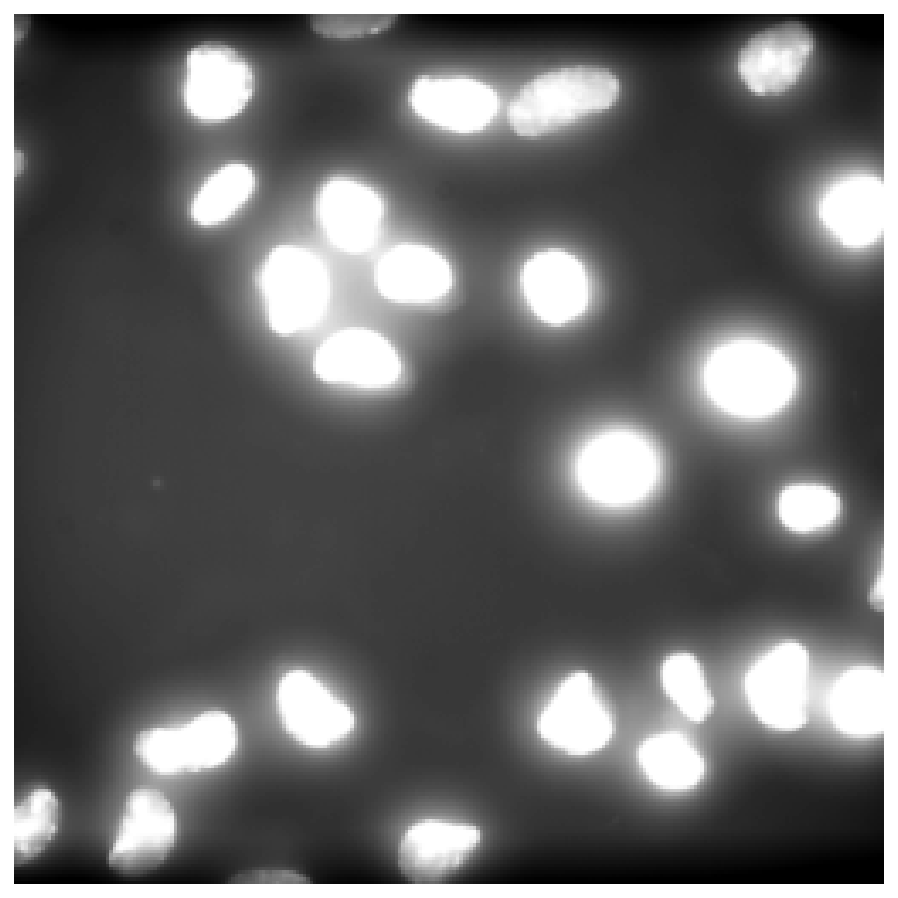

In [36]:
# display tif
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.axis('off');

### Stardist Model

In [37]:
# load stardist model
demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist2D.from_pretrained('2D_demo')
else:
    model = StarDist2D(None, name='stardist', basedir='models')
None;

NOTE: This is loading a previously trained demo model!
      Please set the variable 'demo_model = False' to load your own trained model.


Found model '2D_demo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


Perform predictions on tif with stardist

In [38]:
# perform stardist on image
labels, details = model.predict_instances(img)

Number of Nuclei: 37


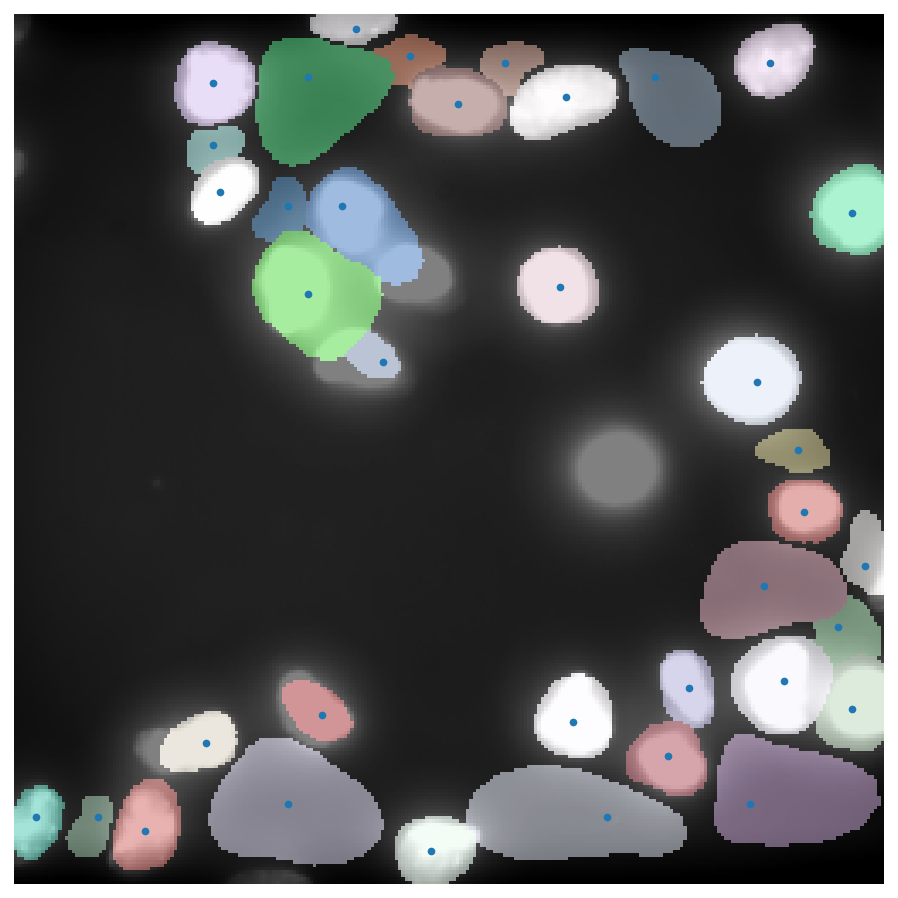

In [39]:
# make predictions more useable 
nuc_center = np.flip(details["points"], -1)
nuc_coord = details["coord"]
print("Number of Nuclei:", nuc_coord.shape[0])
nuc_coord = np.transpose(nuc_coord, axes=(0, 2, 1)) # get points
nuc_coord = np.flip(nuc_coord, -1)

# display nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.axis('off');

Adjust predictions

In [40]:
# change probability
print("Probalities", details["prob"])

Probalities [0.8748571  0.8735217  0.8683703  0.8669518  0.8505342  0.84967816
 0.84797513 0.8415592  0.8396272  0.8319614  0.81987864 0.8164023
 0.8069092  0.80431235 0.7957212  0.7928479  0.78464055 0.7781542
 0.76495564 0.7644058  0.7637461  0.76233387 0.72931623 0.70026356
 0.6186482  0.58333355 0.5825053  0.5750734  0.5709833  0.56054014
 0.5598489  0.55167645 0.53007376 0.5265647  0.5100772  0.498154
 0.4978927 ]


In [41]:
prob = 0.65 # maybe check for standard deviation
prob_nuc_coord = nuc_coord[details["prob"] >= prob]
drop_nuc_coord = nuc_coord[details["prob"] < prob]
prob_nuc_center = nuc_center[details["prob"] >= prob]

Display dropped nuclei

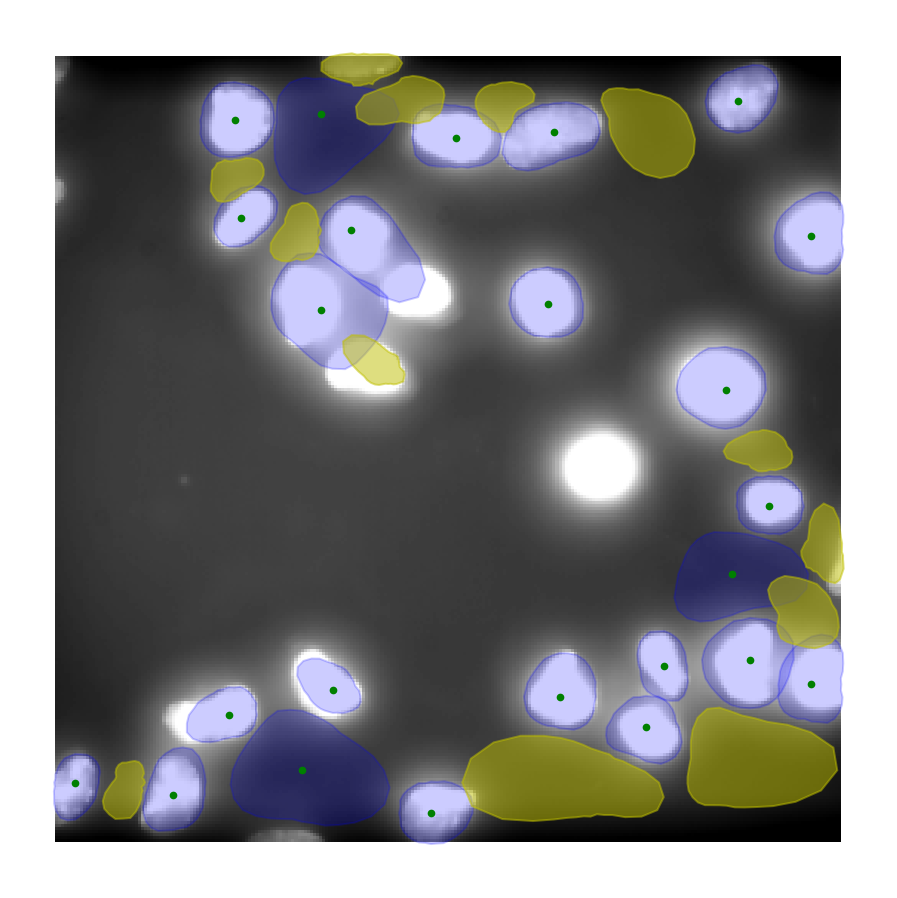

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
for nuc in prob_nuc_coord:
    ax.add_patch(mpatches.Polygon(nuc, color='b', alpha=0.2))
for nuc in drop_nuc_coord:
    ax.add_patch(mpatches.Polygon(nuc, color='y', alpha=0.5))
ax.scatter(prob_nuc_center[...,0], prob_nuc_center[...,1], c="g", s=8, alpha=1)
plt.axis('off');

### Matching

Before matching

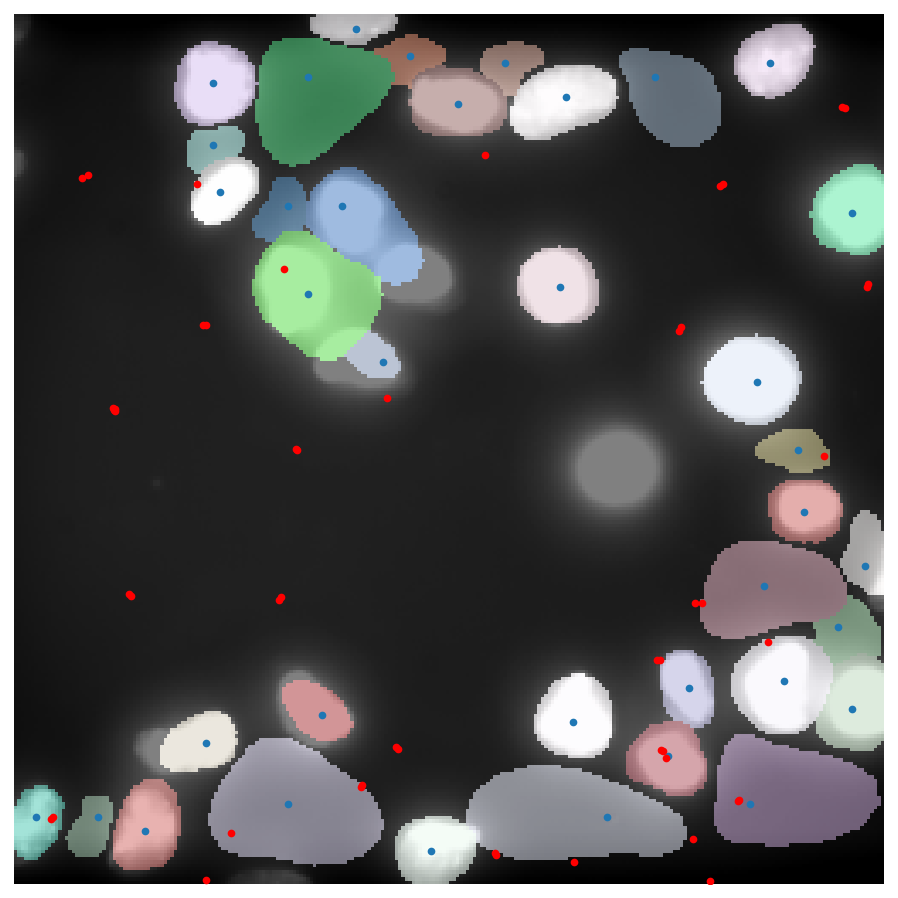

In [43]:
# before matching show centrioles and nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.scatter(cen_coord_x_sc, cen_coord_y_sc, c="r", s=8, alpha=1)
plt.axis('off');

Perform matching

Create a distance matrix between centrioles and nuclei.

In [44]:
# threshold distance
# discard those where the distance is too long
# remember centeroile not matched
dis_thres = 30 # on 256x256
# create ploygons and points
# create distance matrix
C = np.empty([len(list(cen_coord_x_sc)), prob_nuc_coord.shape[0]])
print("Nuclei no", prob_nuc_coord.shape[0], "Distance matrix", C.shape)

for i, cen in enumerate(zip(cen_coord_x_sc, cen_coord_y_sc)):
    #print("Centriole", i)
    pt = geometry.Point(((cen[0], cen[1])))
    
    for j, nuc in enumerate(prob_nuc_coord):
        poly = geometry.Polygon((tuple(map(tuple, nuc))))
        # print(poly.wkt) # prints: 'POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))'

        # The point is in the polygon, so the distance will always be 0.0
        #print("Distance", poly.distance(pt))  # 0.0
        
        dis = poly.distance(pt)
        if dis > dis_thres:
            C[i, j] = -1
        else:
            if dis == 0:
                # inside nuclei, discarde other nuclei
                for n in range(0, len(prob_nuc_coord)):
                    # set all to -1
                    C[i, n] = -1
                C[i, j] = dis
                break
            else:
                C[i, j] = dis

Nuclei no 24 Distance matrix (50, 24)


For C:
row: centrioles
column: nuclei

The distance is calculated from the centriole to the border of the nuclei. 
If the distance is bigger than the distance threshold these will not be matched. 

Centrioles inside a nuclei have distance of 0 and get directly assigned to the nuclei.

Check if already all nuclei only have max 4 centrioles assigned. If more than remove the ones with highest distance

In [45]:
connected_cen_nuc = C >= 0
count_cen = np.count_nonzero(connected_cen_nuc, axis=1) # per centriole
# only count thoose with one connection from cen to nuc
connected_nuc_cen = connected_cen_nuc.transpose()
count_nuc = []
for c in connected_nuc_cen:
    count = 0
    # print(c, len(c))
    for i, n in enumerate(c):
        # print(count_cen[i])
        if n == True:
            # print(count)
            if count_cen[i] == 1:
                count += 1
    count_nuc.append(count)
count_nuc

[0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 5, 1, 0, 4, 0, 0, 3, 1, 2, 0, 2, 0]

How many centrioles are already assigned to a nuclei through one connection and beeing in a centriole.

Reduce the assigments if there are more than 4 centrioles are assigned.

In [46]:
while (np.where(np.array(count_nuc) > 4))[0].shape[0] > 0:
    for j in np.where(np.array(count_nuc) > 4):
        print("Nuclei no", j, "has to many assigned")
        max_dis = 0
        max_idx = None
        for i, c in enumerate(C):
            if c[j] > max_dis:
                max_dis = c[j]
                max_idx = i
        # delete cen assignement 
        C[max_idx, j] = -1
    
    # update
    connected_cen_nuc = C >= 0
    count_cen = np.count_nonzero(connected_cen_nuc, axis=1)
    connected_nuc_cen = connected_cen_nuc.transpose()
    count_nuc = []
    for c in connected_nuc_cen:
        count = 0
        for i, n in enumerate(c):
            if n == True:
                if count_cen[i] == 1:
                    count += 1
        count_nuc.append(count)
count_nuc # no more over 4

Nuclei no [12] has to many assigned
Nuclei no [12] has to many assigned


[0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 4, 1, 0, 4, 0, 0, 3, 1, 2, 0, 2, 0]

All centrioles which are only in one distance threshold of a nuclei get assigned to it.

In [47]:
cen_to_nuc = [-1] * connected_cen_nuc.shape[0]

for i, c in enumerate(count_cen):
    if c == 1:
        cen_to_nuc[i] = (np.where(connected_cen_nuc[i] == True))[0][0]#.astype(int)
    elif c == 0:
        pass # keep as -1
    else:
        cen_to_nuc[i] = None # go into bipartit matching
cen_to_nuc = np.array(cen_to_nuc)

Create new distance matrix out of unmatched centrioles and not fully matched nuclei for bipartite matching.

In [48]:
# put in bipartite
idx_bi = np.where(cen_to_nuc == None)[0]
C_rest = C[idx_bi, :]
# only use thoose nuc which are matched with less than 4 cen
max_matching_nuc_idx = np.where(np.array(count_nuc) == 4)[0]

nuc_nos = 0
nuc_nos_list = []
for c in count_nuc:
    rest = 4-c
    nuc_nos_list.append(rest)
    nuc_nos += rest
C_bi = np.empty([len(list(idx_bi)), nuc_nos])
print("New distance matrix", C_bi.shape)

# place values in new distance matrix
C_to_nuc = []
for i, cen in enumerate(C_rest):
    pos_j = 0
    for j, dis in enumerate(cen):
        no = nuc_nos_list[j]
        C_bi[i, pos_j:pos_j+no] = dis
        pos_j += no

for j, no in enumerate(nuc_nos_list):
    p = j
    if j in max_matching_nuc_idx:
        p += 1
    for n in range(0, no):
        C_to_nuc.append(j)

C_bi[C_bi == -1] = 9999999

New distance matrix (20, 75)


In [49]:
# bipartite matching
row_ind, col_ind = linear_sum_assignment(C_bi)

Delete assingments when over threshold.

In [50]:
del_idx = np.where(C_bi[row_ind, col_ind] > dis_thres)

cen_without_match = row_ind[del_idx]

row_ind_del = np.delete(row_ind, del_idx)
col_ind_del = np.delete(col_ind, del_idx)

Reduce back and join both matching lists.

In [51]:
C_to_nuc = np.array(C_to_nuc)
# reduce nuclei back to original numbers
nuc_no = C_to_nuc[col_ind_del]
nuc_uni = np.unique(nuc_no)
# reduce centrioles back to original numbers
cen_no = idx_bi[row_ind]

# join
for i, c in enumerate(cen_no):
    cen_to_nuc[c] = nuc_no[i]

### Display matching

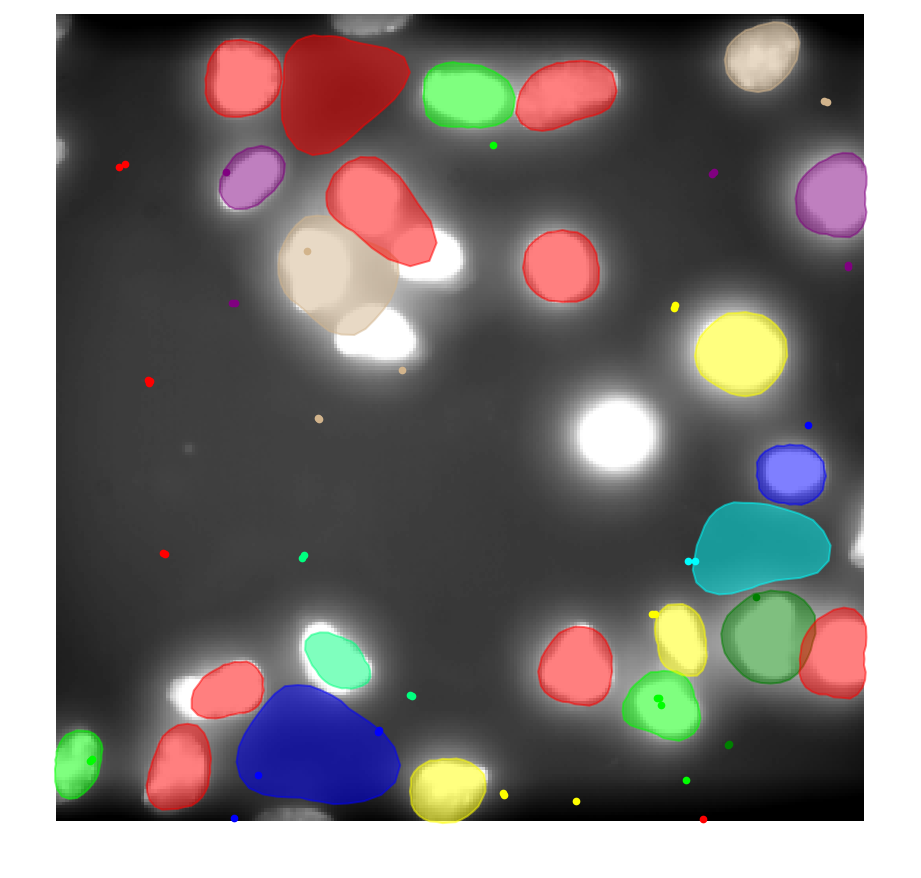

In [52]:
# display matching
color_unmatched = "red"
colors_matched = ['yellow', 'green', 'blue', 'cyan', 'lime', 'purple', 'springgreen', 'tan']

fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
ax.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')

for c, nuc in enumerate(prob_nuc_coord):
    # Nuclei
    if c in cen_to_nuc:
        # print("match, idx nuc", c)
        # matched nuclei
        ax.add_patch(mpatches.Polygon(nuc, color=colors_matched[c % len(colors_matched)], alpha=0.5))
    else:
        # print("no match, idx nuc", c)
        ax.add_patch(mpatches.Polygon(nuc, color=color_unmatched, alpha=0.5))
    # Nuclei center
    # plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
for c, cen in enumerate(list(cen_coord_x_sc)):
    # Centrioles
    if cen_to_nuc[c] != -1:
        ax.scatter(cen_coord_x_sc[c], cen_coord_y_sc[c], c=colors_matched[cen_to_nuc[c] % len(colors_matched)], s=8, alpha=1)
    else:
        ax.scatter(cen_coord_x_sc[c], cen_coord_y_sc[c], c=color_unmatched, s=8, alpha=1)
#ax.scatter(199.875, 242.875, c="blue", s=8, alpha=1)
plt.axis('off');

### Groundtruth Comparision

GT: blue, pred: red


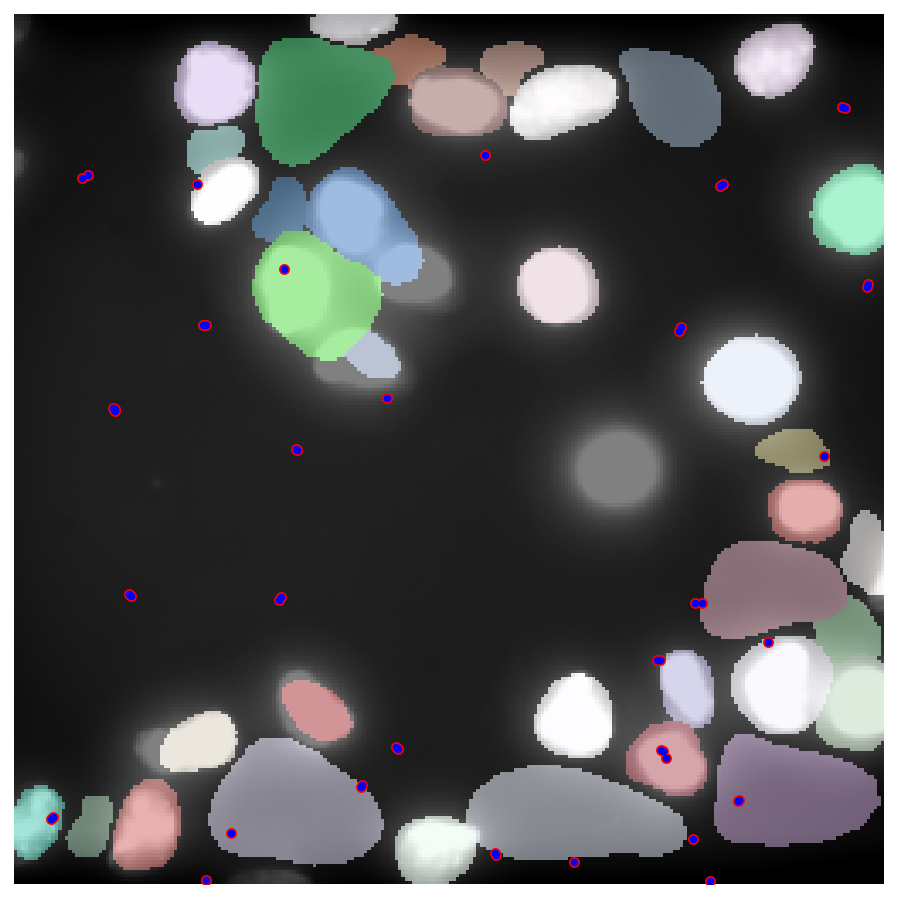

In [53]:
# comparision to groundtruth
# compare centrioles

# load csv GT for centrioles
gt_cen_df = pd.read_csv(path_csv_groundtruth)

# get GT predictions for image
cent_gt_df = pred_cen_df.loc[pred_cen_df['image_name'] == cen_pred_name]

cen_gt_coord_x = np.array(cent_gt_df["x"])
cen_gt_coord_y = np.array(cent_gt_df["y"])
cen_gt_coord = np.array([cen_gt_coord_x, cen_gt_coord_y])

# scale down centrioles
cen_gt_coord_x_sc = cen_gt_coord_x * sc
cen_gt_coord_y_sc = cen_gt_coord_y * sc

# before matching show GT and pred centrioles and nuclei
plt.figure(figsize=(8,8))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
#plt.scatter(nuc_center[..., 0], nuc_center[..., 1], s=8, alpha=1)
plt.scatter(cen_coord_x_sc, cen_coord_y_sc, c="r", s=20, alpha=1)
plt.scatter(cen_gt_coord_x_sc, cen_gt_coord_y_sc, c="b", s=8, alpha=1)
plt.axis('off');

print("GT: blue, pred: red")